# Decision Making from AB Testing

Most presentations of A/B testing tend to emphasize a binary approach to decision making: we run an AB test, then evaluate whether we can reject the null hypothesis of no effect. If we reject the null hypothesis of no effect, then we deploy the change; if not, we maintain the status quo. 

We have also seen some approaches that bring a little much needed nuance to this approach: in our [Trustworthy Online Controlled Experiments](https://www.amazon.com/Trustworthy-Online-Controlled-Experiments-Practical/dp/1108724264), the authors have emphasized that we should evaluate *both* 

- Can we reject the null hypothesis of no effect (to establish our results are statistically significant), and 
- Whether the estimated effect is of *practical significance*, by which they mean "does the effect size look large enough that it would be profitable to deploy."

And finally, you've probably seen cases that do the thing you should probably be doing (at least within this regime):

- Rather than evaluating statistical significance with respect to a null hypothesis of no effect, evaluate statistical significance with respect to a null hypothesis of "the effect is less than the size needed for deployment to be profitable (i.e., less than or equal to the threshold for practical significance)."

In these exercises, we will examine an approach to analyzing the results of an A/B test that is a little less black and white, and I think provides a more holistic, easy to understand, and sophisticated way of interpreting A/B test results. It comes with a couple caveats, but I'd argue none that don't apply to the approaches described above.

In short, under this approach we use all available information to characterize the distribution of our estimated effect. We can do this either by approach our analysis from a maximum likelihood perspective or using bootstrapping. Then we will use a kind of Monte Carlo / simulation based approach to model the likelihood of different outcomes, not just in terms of the likelihood of different estimates of the treatment effect, but also the likelihood different economic outcomes (which are a function of the treatment effect).

To make this approach concrete, we will start by doing some exercises in which this approach is demonstrated. After that, we will circle back to discuss the pros and cons of this approach in detail.

## Exercise Context

In these exercises, we will be working with a tweaked version of data from [IBM Watson Analytics from a marketing A/B test conducted in the state of Washington.](https://www.kaggle.com/datasets/chebotinaa/fast-food-marketing-campaign-ab-test) 

The context in which this data was generated is:

> A fast-food chain plans to add a new item to its menu. However, they are still undecided whether to run a new marketing campaign for promoting the new product. In order to determine whether the promotion will increase sales, a promotion has been deployed at a random sample of stores to promote the new item. Weekly sales of the new item are recorded for the first four weeks.

The data consists of the following variables:

- `MarketID`: unique identifier for market
- `MarketSize`: size of market area by sales
- `LocationID`: unique identifier for store location
- `AgeOfStore`: age of store in years
- `Promotion`: did the location receive the promotion (was it treated).
- `week`: one of four weeks when the promotions were run
- `SalesInThousands`: sales amount for a specific `LocationID`, `Promotion`, and `week`

(And yes, despite my general distaste for them, this is a pretty darn clean dataset. You're welcome. :) )

## Exercises

### Exercise 1

Load the dataset — `WA_Marketing_Campaign.csv` from [this repository.](https://github.com/nickeubank/MIDS_Data/tree/master/fast_food_ab_test) Please use this copy as I've made a couple small modifications to the data for this exercise.

In [1]:
import pandas as pd
import numpy as np

pd.set_option("mode.copy_on_write", True)

weekly_sales = pd.read_csv(
    "https://github.com/nickeubank/MIDS_Data/raw/"
    "master/fast_food_ab_test/WA_Marketing_Campaign.csv"
)

In [2]:
weekly_sales["Promotion"].value_counts()

Promotion
0    188
1    172
Name: count, dtype: int64

### Exercise 2

To simplify the analysis, let's sum up sales from across all four weeks for each store so we only have one observation per store. That way we won't need to worry about the panel structure of the data.

(In a dataset where multiple observations come from the same entity at different points in time, a proper analysis requires accounting for the fact that the different observations for each entity are not independent of one another. We'll talk about that in a later class.) 

You should end up with 90 observations (one per `LocationID`).

In [3]:
weekly_sales["total_sales"] = weekly_sales.groupby("LocationID")[
    "SalesInThousands"
].transform(np.sum)

sales = weekly_sales.drop(columns=["week", "SalesInThousands"]).drop_duplicates()
assert not sales.LocationID.duplicated().any()

/var/folders/fs/h_8_rwsn5hvg9mhp0txgc_s9v6191b/T/ipykernel_72247/3645032325.py:3: FutureWarning: The provided callable <function sum at 0x113562f20> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ].transform(np.sum)


In [4]:
print(f"{len(sales)} observations left.")

90 observations left.


### Exercise 3

Now, using a simple linear regression in `statsmodels`, estimate the simple difference in means between stores with and without the promotion.

(We're skipping a lot of "learn about your data" and "validate your randomization by checking balance" steps  — this is bad practice, but again I want us to stay focused on the analysis and interpretation for this exercise, so you can just trust it's ok.)

In [5]:
import statsmodels.formula.api as smf

fit_model = smf.ols("total_sales ~ Promotion", sales).fit()
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_sales   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.6386
Date:                Wed, 20 Mar 2024   Prob (F-statistic):              0.426
Time:                        21:37:25   Log-Likelihood:                -502.19
No. Observations:                  90   AIC:                             1008.
Df Residuals:                      88   BIC:                             1013.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    221.4579      9.461     23.408      0.000     202.656     240.259
Promotion     10.9382     13.687      0.799      0.426     -16.262      38.139
==============================================================================
Omnibus:                       10.731   Durbin-Watson:                   0.164
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               12.033
Skew:                           0.891   Prob(JB):                      0.00244
Kurtosis:                       2.825   Cond. No.                         2.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Exercise 4

We obviously have some good controls in this dataset, so add in categorical controls for `MarketID` and `log(AgeOfStore)`.

In [6]:
fit_model = smf.ols(
    "total_sales ~ Promotion + C(MarketID) + np.log(AgeOfStore)",
    sales,
).fit()
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_sales   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     298.3
Date:                Wed, 20 Mar 2024   Prob (F-statistic):           6.30e-59
Time:                        21:37:25   Log-Likelihood:                -333.20
No. Observations:                  90   AIC:                             690.4
Df Residuals:                      78   BIC:                             720.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            143.3495      4.939     29.024      0.000     133.517     153.182
C(MarketID)[T.2]     103.6022      5.803     17.854      0.000      92.050     115.155
C(MarketID)[T.3]     197.9546      4.675     42.345      0.000     188.648     207.262
C(MarketID)[T.4]      73.4474      6.025     12.191      0.000      61.453      85.441
C(MarketID)[T.5]      62.1848      5.525     11.254      0.000      51.185      73.185
C(MarketID)[T.6]       3.9928      5.133      0.778      0.439      -6.225      14.211
C(MarketID)[T.7]      37.4080      4.942      7.569      0.000      27.569      47.247
C(MarketID)[T.8]      50.4497      5.011     10.069      0.000      40.474      60.425
C(MarketID)[T.9]      66.3807      5.322     12.473      0.000      55.786      76.976
C(MarketID)[T.10]     79.7188      5.150     15.478      0.000      69.465      89.972
Promotion             19.4720      2.353      8.276      0.000      14.788      24.156
np.log(AgeOfStore)    -1.2697      1.302     -0.975      0.333      -3.863       1.323
==============================================================================
Omnibus:                       10.090   Durbin-Watson:                   2.215
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.333
Skew:                           0.685   Prob(JB):                      0.00570
Kurtosis:                       3.937   Cond. No.                         26.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Bootstrapping

When we run a linear regression — like the one above — standard errors are calculated under the assumption that certain assumptions about our data are true. Generally speaking, those are that our regression errors are normally distributed and homoskedastic.

These analytically-derived standard errors are not the only way one can calculate standard errors, however. A different approach — and one whose validity does not rest on any distributional assumptions: bootstrapping.

Within Frequentist statistics, the meaning of standard errors is "how would our estimates vary if we conducted our study all over again, drawing a new set of observations from the same population each time?" 

Bootstrapping takes this idea seriously. Essentially bootstrapping is the process of simulating drawing new observations from the larger population and observing how our estimate varies across different draws of data. In doing so, bootstrapping only relies on the idea that our data was randomly drawn from a larger population, not any distributional assumptions. In most cases, that makes it much more robust.

OK, but obviously we can't go re-run this marketing experiment again, so how do we get more data? It turns out that sampling from our actual data *with replacement* to get new datasets of the same size as our original dataset is a statistically valid way to simulate re-running the experiment.


### Exercise 4

To create a bootstrapped estimate of the difference in means between treatment and control, create a loop that runs 10,000 times, and at each step:

1. Creates a new dataset by sampling — with replacement — from our original dataset. This new dataset should be the same size as our original dataset.
2. Runs the regression we specified above (total sales over four weeks regressed on `Promotion`, `MarketID`, and `log(AgeOfStore)`). 
3. Extracts the coefficient on `Promotion` from said regression and stores it in a new series or numpy array.

As usual with loops, don't try and write the final loop all at once — put together one pass, then put it in a loop that runs a few times, then finally a loop that runs all 100,000 times.

(Note: the reason we collapsed our data to one-observation-per-LocationID is that if we'd still had multiple weeks per store, we'd have to re-sample our data a little differently. In particular, we'd have to randomly draw from a list of stores, then pull all the observations per store to simulate "drawing" new *stores* with replacement, rather than drawing observations with replacement.)

In [7]:
STEPS = 10_000
estimates = pd.Series(index=range(STEPS))
for i in range(STEPS):
    new_data = sales.sample(len(sales), replace=True)
    model = smf.ols(
        "total_sales ~ Promotion + C(MarketID) + np.log(AgeOfStore)", new_data
    ).fit()
    estimates.iloc[i] = model.params["Promotion"]

In [8]:
print(f"Average estimate is {estimates.mean():.3f}")
print(f"Standard deviation is {estimates.std():.3f}")

Average estimate is 19.459
Standard deviation is 2.288


### Exercise 7

What is the average value of your bootstrapped estimate? What is the standard deviation? Finally, plot a histogram of your estimates. 

If it's helpful, recall that pandas Series have a `.hist()` method for this purpose.

How do they compare with your regression estimates?


<Axes: >

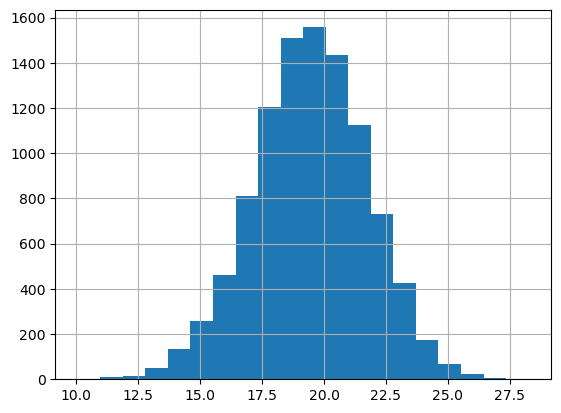

In [9]:
estimates.hist(bins=20)

## Interpreting Our Estimates 

As you will have likely noticed, in this case the bootstrapped estimates of the difference in means between stores with the promotion and without have a very similar mean and standard deviation to the estimates in our linear regression (the standard deviation of the bootstrapped estimates correspond to the standard errors in the regression). That is because, in this case, our regression errors were relatively normally distributed and homoskedastic, meaning that the standard errors calculated analytically by `statsmodels` are actually quite accurate. Indeed, you can also see that our bootstrapped estimates of the difference in means is relatively normally distributed, another consequence of the regression errors being relatively normally distributed. But as we'll see soon, in addition to getting experience with bootstrapping, this approach facilitates something else we want to do.

Before we move on, though, I want to pause for a moment to reflect on how these estimates can be interpreted.

The histogram you plotted above is, technically, an empirical distribution of our estimate of the difference in means between our control stores and those with the promotion. And if we assume that the various assumptions required for a difference in means in an experiment to be a valid estimate of an Average Treatment Effect, then this is also the **empirical distribution of our estimate of the Average Treatment Effect.**

But there's an additional way of thinking about this distribution: in a world where we know nothing about the promotion we're studying except the results of the statistical analysis, this is also our best guess for the probability distribution of the *true* Average Treatment Effect. 

And indeed, given the regression errors for this data are relatively normally distributed, the same could also be said of the results we got from `statsmodels` — as you may recall, a linear regression is numerically equivalent to the Maximum Likelihood Estimator for normally distributed data, meaning we could also say that our best guess for the probability distribution of the value of the Average Treatment Effect is that it is roughly normally distributed with a mean of our original regression coefficient (-19) and a standard deviation of 2.3.

Before I make the statisticians upset, I need to emphasize that the caveat above — that this is only true **in a world where we know nothing about the likely effect of the promotion except the results of the statistical analysis** — is a big one. In the language of Bayesian statistics, saying we know nothing except the results of this analysis is analogous to saying we have "uninformative priors." And that's not a small thing — for example, the company that launched this campaign presumably at least *suspects* the promotion will improve sales. And based on its experience with past promotions, it is also probably pretty confident of the *approximate* magnitude of the biggest effect it may detect. For example, they probably know it won't 10x sales. And if we were doing a proper Bayesian analysis, we would take that kind of information into account by introducing what are called "weakly informative priors." (For a more detailed discussion with equations, hang on till the end of this exercise.)

Nevertheless, I think there is merit in understanding this way of interpreting these results. Yes, a fully Bayesian empirical analysis would likely generate somewhat different results, but unless you are using informative priors (asserting you have a moderate sense of the likely effect of the promotion), the results you get will be relatively similar to what we are getting here. And I think there is merit in understanding this point as the place where these two approaches to statistics coincide, as it were.

And in doing so, I hope this will also provide you with a way to think about our estimates in a richer manner — even if we know it's not exactly right because we know this analysis isn't the *only* thing we know about the world — than the binary, black and white world of A/B testing.

## Outcome Simulation

Interpreting the result above as the probability distribution of the *true* Average Treatment Effect is only interesting if we find a way to do something with it. So let's have some fun using Monte Carlos simulation techniques. 

Suppose we chose to deploy our promotion — what is likely to happen? We know that the most likely outcome is that the promotion will improve sales by our estimated ATE, but what are the range of possible outcomes? Even if we expect the promotion will *probably* make money, maybe what you're really worried about is loss-avoidance, in which case what you want to know is actually "what are the odds we *lose* money?" And how can we integrate information about the cost economics of the promotion into how we answer those questions? Let's find out!

### Exercise 8

Let's start with a simple example. Suppose that our promotion has a fixed cost per store per month. More specifically, suppose that it costs 17,000 dollars per store per month to run the promotion. What is the probability that, if the fast food company deployed the promotion, it would actually *lose* money?

To answer this question, simply figure out how to compute the company's per-store profit as a function of the ATE of the promotion. 

Then, for each estimate of the ATE we bootstrapped, calculate the profit if that estimate turned out to be the true ATE. 

Then calculate the share of bootstrapped "worlds" in which the per-store profits from the promotion were negative.

In [10]:
print(f"Prob of losing money with the promotion is {((estimates - 17) < 0).mean():.1%}")

Prob of losing money with the promotion is 14.1%


### You Did It!

Congratulations! You just did your first "scenario modelling!" And now you can probably see one of the reasons I chose to bootstrap our standard errors — it naturally generated this array of simulated draws of the "true" Average Treatment Effect we can use for modelling!

That isn't to say bootstrapping is strictly necessary to do this type of analysis — because our data was relatively normally distributed, we could have done our scenario planning by using the `numpy.random.normal()` function to simulate draws from the normal distribution implied by our normal `statsmodels` results. But why add that step?

### Exercise 9

OK, that wasn't a particularly complicated scenario. Let's suppose, instead, that the promotion costs $17,000 more per store per month, *and* 50 dollars per 1,000 in sales.

Now what's the probability you make LESS money with the promotion than without?

In [11]:
net_profit = (estimates - 17) - (0.05 * estimates)

print(f"Prob of making less with the promotion is now {(net_profit < 0).mean():.1%}")

Prob of making less with the promotion is now 24.1%


<Axes: >

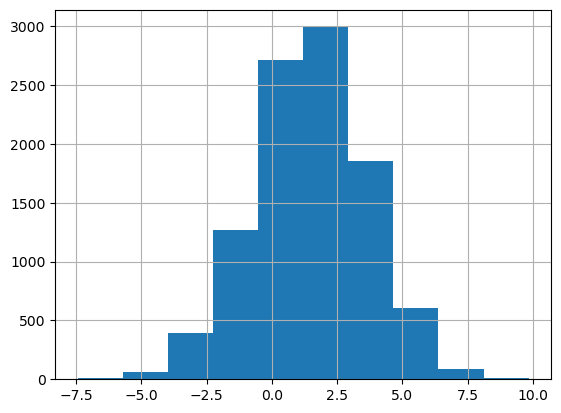

In [12]:
net_profit.hist()

### Exercise 10

Now suppose that the cost of the promotion is:

- 16,000 dollars per store per month, plus 
- 50 dollars per 1,000 in increased sales *for the first 17,000* in increased sales, and 
- 25 dollars per 1,000 after that.

What are the odds you'll lose money?

In [13]:
profits = pd.DataFrame({"ate": estimates})

profits["first_17"] = 17
profits.loc[profits.ate < 17, "first_17"] = profits.loc[profits.ate < 17, "ate"]

profits["over_17"] = 0
profits.loc[profits.ate > 17, "over_17"] = profits.loc[profits.ate > 17, "ate"] - 17


profits["profit"] = (
    (profits.ate - 16) - (profits["first_17"] * 0.05) - (profits["over_17"] * 0.025)
)

print(f"The odds we'll lose money is {(profits['profit'] < 0).mean():.1%}")

The odds we'll lose money is 12.6%


/var/folders/fs/h_8_rwsn5hvg9mhp0txgc_s9v6191b/T/ipykernel_72247/2223901279.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[16.89569719 15.6637186  16.11056695 ... 16.25179418 15.3315546
 16.8096373 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  profits.loc[profits.ate < 17, "first_17"] = profits.loc[profits.ate < 17, "ate"]
/var/folders/fs/h_8_rwsn5hvg9mhp0txgc_s9v6191b/T/ipykernel_72247/2223901279.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.96907815 6.00871939 5.42634738 ... 2.97284399 3.57814255 4.42874029]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  profits.loc[profits.ate > 17, "over_17"] = profits.loc[profits.ate > 17, "ate"] - 17


### Exercise 11

Your boss doesn't just want that top-line number, she also wants to know the Expected Monetary Value of the promotion. What would that be?

In [14]:
profits["profit"].mean()

2.5515868688548027

### Exercise 12

Finally, she wants to see a full probability distribution of outcomes — what does that look like?

<Axes: >

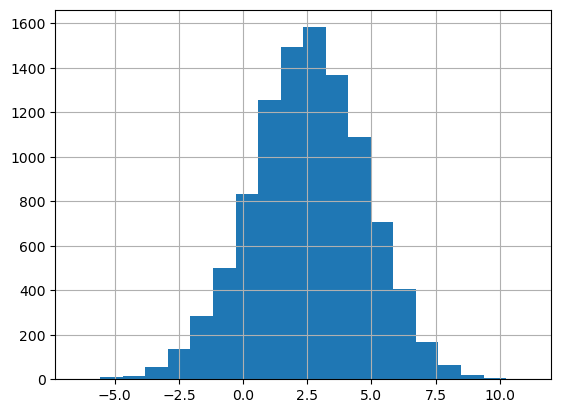

In [15]:
profits["profit"].hist(bins=20)

## The Math

As I promised above, let's take a moment to review why we can think of this distribution as being equal to the probability distribution of our true ATE *if and only if* we are willing to assume we know nothing other than the results of this study. 

### Bayes Rule and Frequentist Statistics

As discussed previously, one of the challenges with the standard, Frequentist approach to A/B testing is that the statistics we get from these analyses (like p-values) rarely correspond to the substantive quantities we care about most.

In statistical notation, our estimate of the distribution of our estimate of the Average Treatment Effect can be written: $P(X|ATE)$ where $X$ is the data generated by our A/B test conditional on the $ATE$.

We sometimes fool ourselves into thinking that this quantity corresponds precisely to what we care about: the probability distribution of the true ATE given our estimate $P(ATE|X)$.

But as you can see, $P(X|ATE) \neq P(ATE|X)$. 

Thankfully, though, Bayes Rule does provide us with a way of determining how these quantities relate to each other. Bayes rule is often written as:

$$P(A | B) = \frac{P(A \cap B)}{P(B)}$$

We can rewrite $P(A \cap B)$ as $P(B | A) * P(A)$, let $A$ be $ATE$ and $B$ be our data $X$ to help us understand our problem better:

$$P(ATE | X) = \frac{P(X|ATE) * P(ATE)}{P(X)}$$

Here, we can see that quantity we are interested in (the probability distribution of $ATE$) on the left-hand side of the equation. We can also see that the first term on the right-hand side of the equation ($P(X|ATE)$) is the distribution we got from bootstrapping (or regular regression packages, conditional on some distributional assumptions). This leaves us with only two terms we need to understand: $P(ATE)$ and $P(X)$.

We call $P(ATE)$ our unconditional *prior* belief about $ATE$ — unconditional because we aren't conditioning on $X$ (the results of our analysis). This, in other words, what values of $ATE$ were plausible before your analysis began.

And $P(X)$? This term is actually kinda annoying and not that interesting, so we generally ignore it. Because we know that the left-hand side of our equation is a probability distribution, we know that the right-hand side has to integrate out to 1 (with respect to all possible values of $A$, which in this case is just whether the conditional probability distribution of $ATE$). So rather than trying to compute $P(X)$ directly, we usually figure out what it *must be* indirectly by figuring out what normalization gives us a valid probability distribution. 

As a result, we often just say that the left-hand side of the equation is *proportional* to the right-hand side, and write this using the $\propto$ symbol:

$$P(ATE | X) \propto P(X|ATE) * P(ATE )$$



### OK, why do I care?

OK, that was a lot of math. Why do I care about all this?

Two reasons:

### Reason 1: It is *critically* important that you understand what p-values and other Frequentist statistics are, and what they are not. 

P-values, as we discussed previously, are the probability of observing our data given the null hypothesis is true — i.e, $P(X|Null)$. It is *not* the probability that the null is true given the data ($P(Null|X)$).

If you get a p-value of 0.05 from an AB test showing that *increasing* latency increases user retention on a website, you should not assume that "Oh, well this only had a 5% probability of happening by chance! Latency must be increasing retention!" Rather, you should say "um, I have a pretty strong sense (a prior, $P(Null)$) that increasing latency does *not* increase retention. So I'm gonna be much more skeptical of that result than an AB test that shows a *decrease* in latency increases user retention with a p-value of 0.05.

### Reason 2: There *is* a special case where $P(ATE| X) = P(X| ATE)$

Suppose you know *nothing* about the treatment you seek to test. All possible outcomes, in your mind, are *equally* likely. This is the case of what is called an *uninformative prior*, and it essentially means $P(ATE)$ is a constant for all possible outcomes.

If $P(ATE)$ is a constant, then $P(ATE| X) \propto P(X| ATE) * c$ for some constant $c$. This implies $P(ATE| X) \propto P(X| ATE)$ (since constants drop out when doing proportionate comparisons). 

Now, I want to emphasize that assuming that all outcomes of $P(ATE)$ are equally likely is a *very* weird thing to assume. After all, you're doing an A/B test because you have some suspicion that your treatment will have an effect, right?

But I think it's helpful to consider this case as a way of understanding the relationship between Frequentist statistics like p-values and the quantities we often actually care about (like the probability that the Null hypothesis of no effect is true): namely, if we are willing to assume that the world started with the study we are conducting and ends with the study we are conducting, and that we know nothing except what is in our dataset, then these two *substantively and theoretically distinct* quantities will be the same.
